In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.',name='Pubmed')
data = dataset[0]

print(f'Dataset : {dataset}')
print(f'Number of graphs : {len(dataset)}')
print(f'Number of Nodes : {data.num_nodes}')
print(f'Number of features : {data.num_features}')
print(f'Number of classes : {dataset.num_classes}')

Dataset : Pubmed()
Number of graphs : 1
Number of Nodes : 19717
Number of features : 500
Number of classes : 3


In [9]:
print('Graph')
print('-'*20)
print(f'Training nodes : {sum(data.train_mask).item()}') #텐서값을 꺼내기
print(f'Validation nodes : {sum(data.val_mask).item()}')
print(f'Test nodes : {sum(data.test_mask).item()}')
print(f'Edges are directed : {data.is_directed()}')
print(f'Graph has isolated nodes : {data.has_isolated_nodes()}')
print(f'Graph has loops : {data.has_self_loops()}')

Graph
--------------------
Training nodes : 60
Validation nodes : 500
Test nodes : 1000
Edges are directed : False
Graph has isolated nodes : False
Graph has loops : False


In [59]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    data,
    num_neighbors=[10,10], #1홉에서 10개, 2홉에서 10개
    batch_size = 16,
    input_nodes = data.train_mask
)

In [60]:
for i,subgraph in enumerate(train_loader):
    print(f'Subgraph {i} : {subgraph}')

Subgraph 0 : Data(x=[516, 500], edge_index=[2, 620], y=[516], train_mask=[516], val_mask=[516], test_mask=[516], n_id=[516], e_id=[620], input_id=[16], batch_size=16)
Subgraph 1 : Data(x=[290, 500], edge_index=[2, 372], y=[290], train_mask=[290], val_mask=[290], test_mask=[290], n_id=[290], e_id=[372], input_id=[16], batch_size=16)
Subgraph 2 : Data(x=[369, 500], edge_index=[2, 453], y=[369], train_mask=[369], val_mask=[369], test_mask=[369], n_id=[369], e_id=[453], input_id=[16], batch_size=16)
Subgraph 3 : Data(x=[231, 500], edge_index=[2, 293], y=[231], train_mask=[231], val_mask=[231], test_mask=[231], n_id=[231], e_id=[293], input_id=[12], batch_size=12)


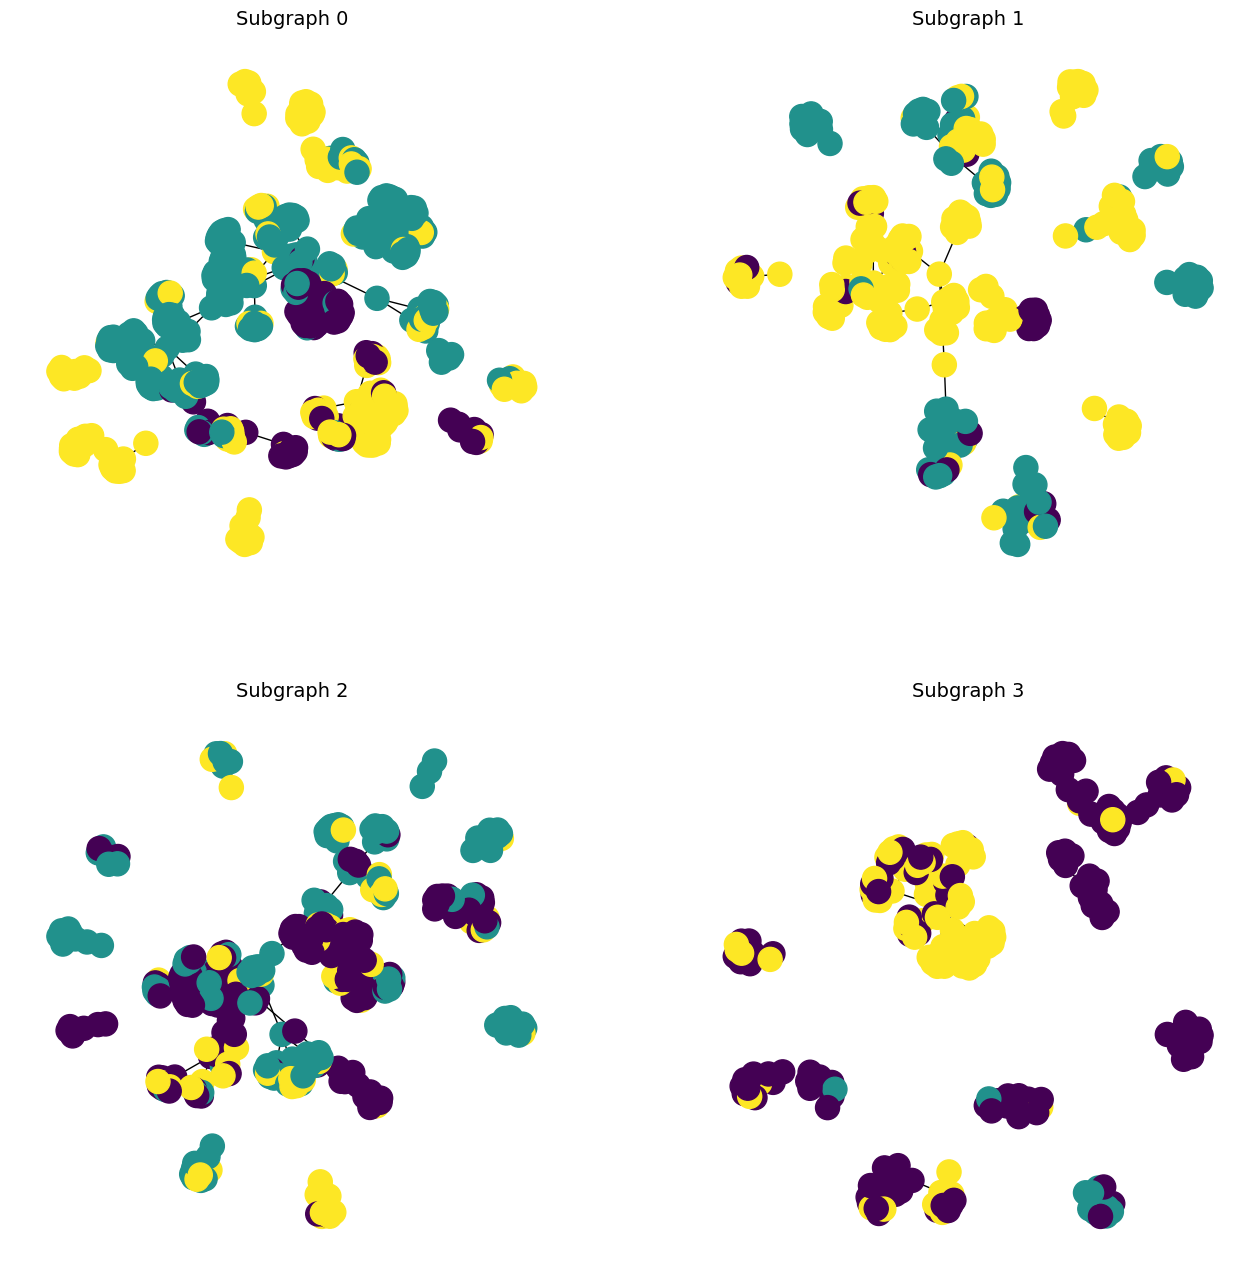

In [62]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig = plt.figure(figsize=(16,16))
for idx, (subdata,pos) in enumerate(zip(train_loader,[221,222,223,224])):
    G = to_networkx(subdata,to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}', fontsize=14)
    plt.axis('off')
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G,seed=0),
                     with_labels=False,
                     node_color=subdata.y)

plt.show()

In [65]:
def accuracy(pred_y,y):
    return ((pred_y==y).sum()/len(y)).item()

In [75]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self,dim_in,dim_h,dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in,dim_h)
        self.sage2 = SAGEConv(dim_h,dim_out)
    
    def forward(self,x,edge_index):
        h = self.sage1(x,edge_index)
        h = torch.relu(h)
        h = F.dropout(h,p=0.5,training=self.training)
        h = self.sage2(h,edge_index)
        return h
    
    def fit(self,data,epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=0.01)
        self.train()
        for epoch in range(epochs+1):
            train_loss,val_loss,train_acc,val_acc = 0,0,0,0
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x,batch.edge_index)
                loss = criterion(out[batch.train_mask],batch.y[batch.train_mask])
                train_loss+=loss
                train_acc+=accuracy(out[batch.train_mask].argmax(dim=1),batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                val_loss = criterion(out[batch.val_mask],batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1),batch.y[batch.val_mask])

            if epoch%20==0:
                print(f'Epoch : {epoch:>5} | Train_Loss : {train_loss/len(train_loader):.4f} | Train_acc : {train_acc*100/len(train_loader):.4f}% | Val_Loss : {val_loss/len(train_loader):.4f} | Val_acc : {val_acc*100/len(train_loader):.4f}%')


    def test(self,data):
        self.eval()
        out = self(data.x,data.edge_index)                
        acc = accuracy(out[data.test_mask].argmax(dim=1),data.y[data.test_mask])
        return acc



In [76]:
graphsage = GraphSAGE(dataset.num_features,64,dataset.num_classes)
print(graphsage)

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)


In [77]:
graphsage.fit(data,200)

Epoch :     0 | Train_Loss : 1.1354 | Train_acc : 30.0756% | Val_Loss : 0.2860 | Val_acc : 38.4615%
Epoch :    20 | Train_Loss : 0.0101 | Train_acc : 100.0000% | Val_Loss : 0.1008 | Val_acc : 79.2674%
Epoch :    40 | Train_Loss : 0.0012 | Train_acc : 100.0000% | Val_Loss : 0.1996 | Val_acc : 70.5628%
Epoch :    60 | Train_Loss : 0.0023 | Train_acc : 100.0000% | Val_Loss : 0.1020 | Val_acc : 66.5751%
Epoch :    80 | Train_Loss : 0.0025 | Train_acc : 100.0000% | Val_Loss : 0.0669 | Val_acc : 73.9927%
Epoch :   100 | Train_Loss : 0.0004 | Train_acc : 100.0000% | Val_Loss : 0.2182 | Val_acc : 70.3030%
Epoch :   120 | Train_Loss : 0.0017 | Train_acc : 100.0000% | Val_Loss : 0.1101 | Val_acc : 76.2879%
Epoch :   140 | Train_Loss : 0.0001 | Train_acc : 100.0000% | Val_Loss : 0.1693 | Val_acc : 84.8260%
Epoch :   160 | Train_Loss : 0.0002 | Train_acc : 100.0000% | Val_Loss : 0.1594 | Val_acc : 71.7949%
Epoch :   180 | Train_Loss : 0.0002 | Train_acc : 100.0000% | Val_Loss : 0.0032 | Val_acc : 

In [78]:
test_acc = graphsage.test(data)
print(f'Test_acc : {test_acc*100:.4f}%')

Test_acc : 74.4000%


PPI 단백질

In [79]:
from torch_geometric.datasets import PPI

train_dataset = PPI(root='.',split='train')
val_dataset = PPI(root='.',split='val')
test_dataset = PPI(root='.',split='test')

Extracting ./ppi.zip
Processing...
Done!


In [ ]:
train_dataset,val_dataset,test_dataset #이전에 다룬 그래프는 단일 그래프, 지금은 다중 그래프

(PPI(20), PPI(2), PPI(2))

In [ ]:
from torch_geometric.data import Batch
from torch_geometric.loader import NeighborLoader

train_data = Batch.from_data_list(train_dataset)
loader = NeighborLoader(train_data,
                        batch_size = 2048,
                        shuffle=True,
                        num_neighbors=[20,10],
                        num_workers = 2,
                        persistent_workers=True)

In [ ]:
train_data # 배치는 그래프를 구분하는 정보를 담고 있음 !

DataBatch(x=[44906, 50], edge_index=[2, 1226368], y=[44906, 121], batch=[44906], ptr=[21])

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset,batch_size=2)
val_loader = DataLoader(val_dataset,batch_size=2) #val_dataset은 그래프가 2개, 배치사이즈가 2개이므로, 1개의 배치만 존재
test_loader = DataLoader(test_dataset,batch_size=2) #test_dataset은 그래프가 2개, 배치사이즈가 2개이므로, 1개의 배치만 존재

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [104]:
from torch_geometric.nn import GraphSAGE #PyG의 GraphSAGE 호출

model = GraphSAGE(in_channels=train_dataset.num_features,hidden_channels=512,num_layers=2,
                  out_channels=train_dataset.num_classes).to(device)

In [122]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)

def fit():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x,data.edge_index) 
        loss = criterion(out,data.y)
        total_loss += loss.item() * data.num_graphs #criterion에서 평균된 loss를 다시 원복
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset) #전체 로스 펑균

In [123]:
from sklearn.metrics import f1_score
@torch.no_grad
def test(loader):
    model.eval()
    data = next(iter(loader))
    out = model(data.x.to(device),data.edge_index.to(device))
    preds = (out>0).float().cpu() #로짓값을 sigmoid 없이 이진예측을 만듦.
    # logit > 0 => 확률이 0.5이상 / logit < 0 => 확률이 0.5이하
    # boolean을 float형태로 변환 = {False :0 , True: 1}
    y,pred = data.y.numpy(),preds.numpy() 
    return f1_score(y,pred,average='micro') if pred.sum()>0 else 0 # 분모 0 방지

In [124]:
for epoch in range(301):
    loss = fit()
    val_f1 = test(val_loader)
    if epoch%50==0:
        print(f'Epoch : {epoch:>3} | Train_loss : {loss:.3f} | Val_F1 : {val_f1:.4f}')
    

Epoch :   0 | Train_loss : 0.588 | Val_F1 : 0.4144
Epoch :  50 | Train_loss : 0.189 | Val_F1 : 0.8432
Epoch : 100 | Train_loss : 0.142 | Val_F1 : 0.8781
Epoch : 150 | Train_loss : 0.123 | Val_F1 : 0.8937
Epoch : 200 | Train_loss : 0.107 | Val_F1 : 0.9027
Epoch : 250 | Train_loss : 0.098 | Val_F1 : 0.9094
Epoch : 300 | Train_loss : 0.099 | Val_F1 : 0.9099


In [125]:
print(f'Test F1 Score : {test(test_loader):.4f}')

Test F1 Score : 0.9314
